In [ ]:
# notebook for calculating the theta sqrt plot from the .p file created in 1

The theta sqr data is important to select only the events which is coming from direction close to the pointing source

In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText

In [2]:
# Here we are loading the data we saved before 
inFile = open('data_integral.p','rb')
description = pickle.load(inFile)

In [3]:
# Find indices corresponding to the different variables
Length_idx = np.nonzero(description=='Length')[0][0]
Width_idx = np.nonzero(description=='Width')[0][0]
NumIslands_idx = np.nonzero(description=='NumIslands')[0][0]
NumUsedPixels_idx = np.nonzero(description=='NumUsedPixels')[0][0]
Leakage1_idx = np.nonzero(description=='Leakage1')[0][0]
Size_idx = np.nonzero(description=='Size')[0][0]
X_idx = np.nonzero(description=='X')[0][0]
Y_idx = np.nonzero(description=='Y')[0][0]
CosDelta_idx = np.nonzero(description=='CosDelta')[0][0]
SinDelta_idx = np.nonzero(description=='SinDelta')[0][0]
M3Long_idx = np.nonzero(description=='M3Long')[0][0]
SlopeLong_idx = np.nonzero(description=='SlopeLong')[0][0]
MeanX_idx = np.nonzero(description=='MeanX')[0][0]
MeanY_idx = np.nonzero(description=='MeanY')[0][0]

In [4]:
def FillHistogram(bins,n,value,weight=1):
    idx = np.searchsorted(bins,value)
    if not idx==0 and not idx>n.size:
        n[idx-1]+=weight

In [5]:
# useful values
mm2deg = 0.0117193246260285378

# Create bins for the histogram
bins = np.linspace(0,0.3,31)
non = np.zeros(30)
noff = np.zeros(30)

In [6]:
while True:
    try:
        Event = pickle.load(inFile)
    except:
        break

    # Intialize all variables needed in the calculations
    Length = Event[Length_idx]
    Width = Event[Width_idx]
    NumIslands = Event[NumIslands_idx]
    NumUsedPixels = Event[NumUsedPixels_idx]
    Leakage1 = Event[Leakage1_idx]
    Size = Event[Size_idx]
    X = Event[X_idx]
    Y = Event[Y_idx]
    CosDelta = Event[CosDelta_idx]
    SinDelta = Event[SinDelta_idx]
    M3Long = Event[M3Long_idx]
    SlopeLong = Event[SlopeLong_idx]
    MeanX = Event[MeanX_idx]
    MeanY = Event[MeanY_idx]

    # First calculate all cuts to speedup the analysis
    area =  np.pi*Width*Length

    # The abberation correction does increase also Width and Length by 1.02
    cutq = (NumIslands<3.5 and NumUsedPixels>5.5 and Leakage1<0.1)
    if not cutq:
        continue

    cut0 = area<(np.log10(Size)*898-1535)
    if not cut0:
        continue

    # Loop over all wobble positions in the camera
    for angle in range(0,360,60):
        
        # ----------- Source dependent parameter calculation ----------
        cr = np.cos(np.deg2rad(angle))
        sr = np.sin(np.deg2rad(angle))

        # the position of the source in each wobble position
        px = cr*X-sr*Y 
        py = cr*Y+sr*X  

        # distance of the center of gravity to the source center in each wobble position
        dx = MeanX-px*1.02  
        dy = MeanY-py*1.02

        norm = np.sqrt(dx*dx+dy*dy)
        dist = norm*mm2deg
        
        # these are unitary vectors in the ellipse frame, lx and ly are alligned with the short and long ellipse axes
        lx = np.min([np.max([(CosDelta*dy-SinDelta*dx)/norm,-1.]),1.])
        ly = np.min([np.max([(CosDelta*dx+SinDelta*dy)/norm,-1.]),1.])

        alpha = np.arcsin(lx)
        sgn = np.sign(ly)

        # ------------------------ Application ---------------------
        # both help to say from which of the two solutions for disp i should use
        m3l = M3Long*sgn*mm2deg
        slope = SlopeLong*sgn/mm2deg

        # -------------------------- Analysis ----------------------
        xi = 1.39252+0.154247*slope+1.67972*(1-1/(1+4.86232*Leakage1))

        sign1 = m3l+0.07
        sign2 = (dist-0.5)*7.2-slope

        disp = (-xi if (sign1<0 or sign2<0) else xi)*(1-Width/Length)
        
        # this is the formula c^2 = a^2 + b^2 - 2ab*cos alpha , cos² alpha + sin² = 1
        # in this case dist = distance of the ellipse center to the pointing 
        thetasq = disp*disp+dist*dist-2*disp*dist*np.sqrt(1-lx*lx)

        if angle==0:
            FillHistogram(bins,non,thetasq)
            thetasq_list_on.append(thetasq)
        else:
            FillHistogram(bins,noff,thetasq)
            thetasq_list_off.append(thetasq)

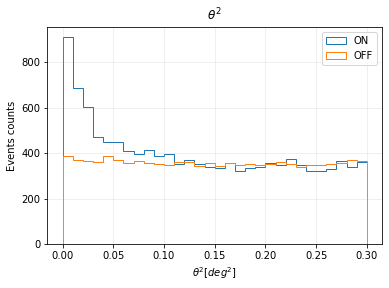

In [7]:
plt.hist(bins[:-1],bins=bins,histtype='step',weights=non, label='ON')
plt.hist(bins[:-1],bins=bins,histtype='step',weights=noff*(1/5), label='OFF')
plt.title(r'$\theta^{2}$')
plt.grid(alpha=0.25)
plt.xlabel(r'$\theta^{2} [deg^{2}]$')
plt.ylabel('Events counts')
plt.legend()

In [15]:
cut_theta2 = 0.04

In [16]:
def LiMa_significance(N_on, N_off, alpha):
    '''function to calculate how significance the excess of the on region is compared to off region
    N_on the total counts in ON region
    N_off the total counts in off region
    alpha the ratio of ON/OFF areas, in this case 1/5'''
    
    term1 = ( ( (1+alpha)/alpha )*(N_on/(N_on+N_off)) )
    term2 = (1+alpha)*(N_off/(N_on+N_off))
    brakets = N_on*np.log(term1) + N_off*np.log(term2)
    
    return np.sqrt(2)*brakets**(1/2)

In [17]:
# here is to select the bins that are below the cut in theta2
mask_theta2 = bins < cut_theta2

In [18]:
print(bins[mask_theta2])

[0.   0.01 0.02 0.03]


In [19]:
# summing the counts that survived the cut in theta2
N_on = np.sum(non[mask_theta2[:-1]])
N_off = np.sum(noff[mask_theta2[:-1]])

In [20]:
# calculating the significance
significance = LiMa_significance(N_on, N_off, 1/5)
print(significance)

24.751572221016268


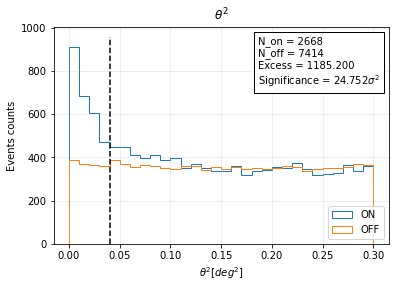

In [21]:
plt.hist(bins[:-1],bins=bins,histtype='step',weights=non, label='ON')
plt.hist(bins[:-1],bins=bins,histtype='step',weights=noff*(1/5), label='OFF')
plt.vlines(x=cut_theta2, ymin=plt.ylim()[0], ymax=plt.ylim()[1], ls='--', color='black')
plt.title(r'$\theta^{2}$')
plt.grid(alpha=0.25)
plt.xlabel(r'$\theta^{2} [deg^{2}]$')
plt.ylabel('Events counts')
plt.legend(loc='lower right')

ax = plt.gca()
at0 = AnchoredText(
                f"N_on = {np.int(N_on)}\n"
                f"N_off = {np.int(N_off)}\n"
                f"Excess = {(N_on - N_off*1/5) :.3f}\n"
                f"Significance = {significance:.3f}"
                r"$\sigma^{2}$"
                , loc='upper right')
ax.add_artist(at0)